# Introduction
As of 2025-06-12, the volunteers at rangers.urbanrivers have added 59,351 observations.


In [1]:
# Data Handling
import pandas as pd

# IO - getting files and images
from kaggle_secrets import UserSecretsClient
import requests
import json
import os
import urllib.parse

print("==== Loaded Libraries ====")

==== Loaded Libraries ====


In [2]:
%%time
# Define the list of species we are going to pull
species_list = [
    "Canis latrans", "Canis familiaris", "Felis catus", "Castor canadensis",
    "Ondatra zibethicus", "Sylvilagus floridanus", "Sciurus carolinensis",
    "Procyon lotor", "Lontra canadensis", "Didelphis virginiana",
    "Anas platyrhynchos", "Branta canadensis", "Trachemys scripta elegans",
    "Chelydra serpentina", "Chrysemys picta", "Apalone spinifera",
    "Columba livia", "Sturnus vulgaris", "Agelaius phoeniceus",
    "Passer domesticus", "Turdus migratorius", "Corvus brachyrhynchos",
    "Ardea herodias", "Nycticorax nycticorax", "Astur cooperii",
    "Actitis macularius", "Aix sponsa", "Ardea alba", "Cardinalis cardinalis",
    "Cyprinus carpio"
]
species_encoded = ",".join([urllib.parse.quote(s) for s in species_list])

# Get URLs for organising download links
user_secrets = UserSecretsClient()
obs_url = user_secrets.get_secret("OBS_BASE")

def fetch_all_obs():
    batch_size = 1000
    page = 1
    all_images = []


    while True:
        url = f"{obs_url}?species={species_encoded}&limit={batch_size}&page={page}"
        
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Request failed at page {page} with status code {response.status_code}")
            break

        data = response.json()
        images = data.get("images", [])
        if not images:
            # No more images left
            break

        all_images.extend(images)
        print(f"Page {page}: Retrieved {len(images)} image observations")
        page += 1

    return all_images


# Fetch JSON for all images
try:
    print("===== Starting JSON Fetch =====")
    obs_json = fetch_all_obs()
except Exception as e:
    print(f"Problem with fetch: {e}")
else:
    print("===== Completed JSON Fetch =====")


===== Starting JSON Fetch =====
Page 1: Retrieved 1000 image observations
Page 2: Retrieved 1000 image observations
Page 3: Retrieved 1000 image observations
Page 4: Retrieved 1000 image observations
Page 5: Retrieved 1000 image observations
Page 6: Retrieved 1000 image observations
Page 7: Retrieved 1000 image observations
Page 8: Retrieved 1000 image observations
Page 9: Retrieved 1000 image observations
Page 10: Retrieved 1000 image observations
Page 11: Retrieved 1000 image observations
Page 12: Retrieved 1000 image observations
Page 13: Retrieved 88 image observations
===== Completed JSON Fetch =====
CPU times: user 813 ms, sys: 130 ms, total: 943 ms
Wall time: 39.6 s


# Start Here to avoid re-querying the api

In [3]:
%%time
# Process the JSON
def process_obs_json(obs):
    records = []
    for ob in obs:
        media_id = ob.get("mediaID")
        public_url = ob.get("publicURL")
        for species in ob.get("speciesConsensus", []):
            scientific_name = species.get("scientificName")
            observation_count = species.get("observationCount")
            records.append({
                "mediaID": media_id,
                "publicURL": public_url,
                "scientificName": scientific_name,
                "observationCount": observation_count
            })
    df = pd.DataFrame(records)

    return df

df = process_obs_json(obs_json)

with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df.head())

os.makedirs('/kaggle/working/data', exist_ok=True)
df.to_csv('/kaggle/working/data/initial_processed_data.csv', index=False)

print(len(df))

,mediaID,publicURL,scientificName,observationCount
0,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,Canis familiaris,1
1,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,None,2
2,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,Canis familiaris,1
3,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,None,2
4,ae560a001909c62e2993a1d2aa09c182,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0170.JPG,Canis familiaris,1


17980
CPU times: user 138 ms, sys: 7.68 ms, total: 145 ms
Wall time: 149 ms


In [4]:
df = pd.read_csv("/kaggle/working/data/initial_processed_data.csv")

In [5]:
# seems like we might have duplicates for every image and observation - just want a validated list
df2 = df.drop_duplicates().reset_index(drop=True)
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df2.head())

print(f'Total rows: {len(df2)}\n')
print(df2['scientificName'].value_counts())

,mediaID,publicURL,scientificName,observationCount
0,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,Canis familiaris,1
1,9189635ca915cb3507c37f0b4c529846,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0158.JPG,NaN,2
2,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,Canis familiaris,1
3,9a6f3bbe7d62565c2ce5b632c0dfad55,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0160.JPG,NaN,2
4,ae560a001909c62e2993a1d2aa09c182,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-01-30_prologis_02/DCIM/100MEDIA/SYFW0170.JPG,Canis familiaris,1


Total rows: 17329

scientificName
Branta canadensis            4115
Anas platyrhynchos           3254
Trachemys scripta elegans    2063
Apalone spinifera            1218
Actitis macularius           1121
                             ... 
Marmota monax                   1
Leporidae                       1
Actinopterygii                  1
Castorimorpha                   1
Ictaluridae                     1
Name: count, Length: 87, dtype: int64


In [6]:
# Filter to species with at least 3 votes
df3 = df2[(df2['observationCount'] >= 3) ]
df3.loc[:, 'scientificName'] = df3['scientificName'].fillna("blank")
df3 = df3.sort_values(by='observationCount', ascending=False).reset_index(drop=True)
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df3.head())

print(f'Total rows: {len(df3)}\n')
print(df3['scientificName'].value_counts())

,mediaID,publicURL,scientificName,observationCount
0,ff2c1b7718fd23de7d4f13086aa94fa3,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW2126.JPG,blank,10
1,2b38de3083349c8aafce8b6d66bb7aeb,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW2954.JPG,Castor canadensis,9
2,f4e25c036a53d2d204de57c5fd3ce782,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW2953.JPG,Castor canadensis,9
3,eae1c8e369ca98c1fde6961ce1389f68,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW2128.JPG,blank,9
4,8a95a3db6dac5ec39a1d7d4d3866b694,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW2955.JPG,Castor canadensis,9


Total rows: 1801

scientificName
Branta canadensis            626
blank                        228
Anas platyrhynchos           223
Actitis macularius           213
Canis familiaris             144
Trachemys scripta elegans    143
Castor canadensis             70
Apalone spinifera             35
Turdus migratorius            29
Sylvilagus floridanus         28
Ondatra zibethicus            13
Procyon lotor                 11
Passer domesticus             11
Ardea herodias                11
Nycticorax nycticorax          4
Spizelloides arborea           3
Sturnus vulgaris               3
Larus delawarensis             2
Quiscalus quiscula             1
Fulica americana               1
Rattus norvegicus              1
Aves                           1
Name: count, dtype: int64


In [7]:
# This might be a multiple classification problem - let's see if things change when we group by and list the scientific names
df3_grouped = df3.groupby(['mediaID', 'publicURL'])['scientificName'] \
    .agg(lambda x: ';'.join(sorted(set(x)))) \
    .reset_index()

# To keep classes where only blank and yet not ones containing blank
def is_only_blank(label_str):
    return label_str.strip() == "blank"

# Filter: keep rows where "blank" is not in the list OR is the only label
# This is because sometimes people are categorizing multiple blanks in a row and do not see the animal while zoned out.
df3_grouped = df3_grouped[
    ~df3_grouped['scientificName'].str.contains(';blank') |
    df3_grouped['scientificName'].apply(is_only_blank)
]

# Show the results
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df3_grouped.head())
    
print(f'Total rows: {len(df3_grouped)}\n')
print(df3_grouped['scientificName'].value_counts())

,mediaID,publicURL,scientificName
0,0017307382475a160ccf074bf437115b,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/100MEDIA/SYFW0781.JPG,Anas platyrhynchos;Branta canadensis
1,002fe9a5dc3a1bf6b14298838bae6982,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/101SYCAM/SYEW0819.JPG,Branta canadensis
2,0032759e5c6eb2df7b23b58e9c68f59c,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3154.JPG,Actitis macularius
3,00bafc77dcb4d686a46e181ea50d3104,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW1550.JPG,blank
4,00bcb26cd24bd4dce3f2f47f848faf63,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW7278.JPG,Branta canadensis


Total rows: 1379

scientificName
Branta canadensis                                                 556
Anas platyrhynchos                                                166
Actitis macularius                                                159
blank                                                             101
Trachemys scripta elegans                                          56
Actitis macularius;Trachemys scripta elegans                       51
Castor canadensis                                                  48
Anas platyrhynchos;Branta canadensis                               40
Turdus migratorius                                                 29
Sylvilagus floridanus                                              27
Canis familiaris                                                   26
Apalone spinifera;Trachemys scripta elegans                        18
Ondatra zibethicus                                                 11
Passer domesticus                                        

There are a few that are classified as multiple species - for now, let's focus on those that are just single labeled

In [8]:
# Save the filtered df as a starting point for image requests
df3_grouped.to_csv("/kaggle/working/data/all_labeled_species_urls.csv", index=False)

In [9]:
# We're going to focus on single species labeled images and blanks for an attempt at training a simple classification model - a scientific name always has at least one space - so we'll filter one last time.
df4 = df3_grouped[(~df3_grouped["scientificName"].str.contains(";")) & (df3_grouped["scientificName"].str.contains(" ")) | (df3_grouped["scientificName"] == 'blank')]

# Show the results
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df4.head())
    
print(f'Total rows: {len(df4)}\n')
print(df4['scientificName'].value_counts())

,mediaID,publicURL,scientificName
1,002fe9a5dc3a1bf6b14298838bae6982,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/101SYCAM/SYEW0819.JPG,Branta canadensis
2,0032759e5c6eb2df7b23b58e9c68f59c,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3154.JPG,Actitis macularius
3,00bafc77dcb4d686a46e181ea50d3104,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW1550.JPG,blank
4,00bcb26cd24bd4dce3f2f47f848faf63,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW7278.JPG,Branta canadensis
5,00f02cfbbb34ec0ba7be807729a1af13,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/101MEDIA/SYFW0304.JPG,Anas platyrhynchos


Total rows: 1228

scientificName
Branta canadensis            556
Anas platyrhynchos           166
Actitis macularius           159
blank                        101
Trachemys scripta elegans     56
Castor canadensis             48
Turdus migratorius            29
Sylvilagus floridanus         27
Canis familiaris              26
Ondatra zibethicus            11
Passer domesticus             10
Procyon lotor                 10
Ardea herodias                 9
Apalone spinifera              6
Nycticorax nycticorax          4
Sturnus vulgaris               3
Spizelloides arborea           3
Quiscalus quiscula             1
Fulica americana               1
Larus delawarensis             1
Rattus norvegicus              1
Name: count, dtype: int64


In [10]:
# save the single species images with at least n observations so we can 
n_obs_minimum = 25
species_counts = df4['scientificName'].value_counts()
species_to_keep = species_counts[species_counts > n_obs_minimum].index

df5 = df4[df4['scientificName'].isin(species_to_keep)]
df5.to_csv(f'/kaggle/working/data/species_over{n_obs_minimum}.csv', index=False)

# Show the results
with pd.option_context('display.width', 0, 'display.max_colwidth', None):
    display(df5.head())
    
print(f'Total rows: {len(df5)}\n')
print(df5['scientificName'].value_counts())

,mediaID,publicURL,scientificName
1,002fe9a5dc3a1bf6b14298838bae6982,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/101SYCAM/SYEW0819.JPG,Branta canadensis
2,0032759e5c6eb2df7b23b58e9c68f59c,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-03_UR011/DCIM/100MEDIA/SYFW3154.JPG,Actitis macularius
3,00bafc77dcb4d686a46e181ea50d3104,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-03-23_WildMileNorth/DCIM/100MEDIA/SYFW1550.JPG,blank
4,00bcb26cd24bd4dce3f2f47f848faf63,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-05-12_Prologis/DCIM/100SYCAM/SYEW7278.JPG,Branta canadensis
5,00f02cfbbb34ec0ba7be807729a1af13,https://urbanriverrangers.s3.amazonaws.com/images/2024/2024-06-27_UR011/DCIM/101MEDIA/SYFW0304.JPG,Anas platyrhynchos


Total rows: 1168

scientificName
Branta canadensis            556
Anas platyrhynchos           166
Actitis macularius           159
blank                        101
Trachemys scripta elegans     56
Castor canadensis             48
Turdus migratorius            29
Sylvilagus floridanus         27
Canis familiaris              26
Name: count, dtype: int64


In [11]:
%%time
import random
from tqdm import tqdm

# Select the df cleaning state we want to use
df = df5

base_dir = '/kaggle/working/images'
test_dir = '/kaggle/working/_tests'
os.makedirs(test_dir, exist_ok=True)

# Shuffle the whole DataFrame first to ensure randomness
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
grouped = list(df_shuffled.groupby('scientificName'))

for species, group in grouped:
    group = group.dropna(subset=['publicURL'])
    if len(group) < 26:
        continue  # Skip if not enough images

    selected = group.sample(n=26, random_state=42)
    train_samples = selected.iloc[:25]
    test_sample = selected.iloc[25]

    species_folder = species.replace(' ', '_')
    species_dir = os.path.join(base_dir, species_folder)
    os.makedirs(species_dir, exist_ok=True)

    # Single tqdm bar per species while downloading 25 images
    with tqdm(total=25, desc=f"{species_folder:30}", ncols=100) as pbar:
        for _, row in train_samples.iterrows():
            image_path = os.path.join(species_dir, f"{row['mediaID']}.jpg")
            try:
                response = requests.get(row['publicURL'], timeout=5)
                if response.status_code == 200:
                    with open(image_path, 'wb') as f:
                        f.write(response.content)
            except Exception as e:
                print(f"Failed: {row['mediaID']} - {e}")
            pbar.update(1)  # Update tqdm bar per image

    # Save 1 test image
    test_image_path = os.path.join(test_dir, f"{species_folder}.jpg")
    try:
        response = requests.get(test_sample['publicURL'], timeout=5)
        if response.status_code == 200:
            with open(test_image_path, 'wb') as f:
                f.write(response.content)
    except Exception as e:
        print(f"Failed test image {test_sample['mediaID']}: {e}")

blank                         : 100%|███████████████████████████████| 25/25 [00:07<00:00,  3.20it/s]


CPU times: user 2.97 s, sys: 1.19 s, total: 4.16 s
Wall time: 1min 15s


CPU times: user 19.4 s, sys: 7.54 s, total: 27 s
Wall time: 30.2 s


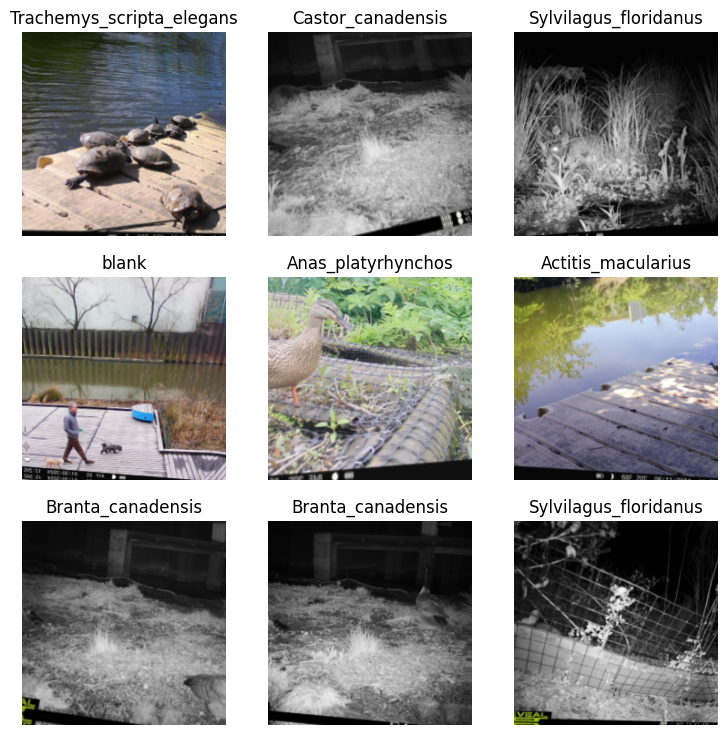

In [12]:
%%time
from fastai.vision.all import *

path = Path('/kaggle/working/images')

# Ignore test folder during training
dls = ImageDataLoaders.from_folder(
    path,
    train='.',       # Train data is in the species folders
    valid_pct=0.2,   # FastAI will split off a validation set
    seed=42,
    item_tfms=Resize(224),  # Resize all images to 224x224
    batch_tfms=aug_transforms(),
)

dls.show_batch(max_n=9)


In [13]:
%%time
learn = vision_learner(dls, resnet18, metrics=error_rate)

learn.model = learn.model.cuda()
print(next(learn.model.parameters()).device)

learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,3.204151,6.366326,0.911111,00:35


epoch,train_loss,valid_loss,error_rate,time
0,2.265335,3.759986,0.822222,00:36
1,2.145396,1.804199,0.488889,00:37
2,1.774322,1.107911,0.311111,00:35
3,1.460763,0.931046,0.244444,00:34
4,1.255448,0.889635,0.266667,00:37


CPU times: user 3.78 s, sys: 1.56 s, total: 5.34 s
Wall time: 3min 37s


<Axes: title={'center': 'Probably: Branta_canadensis (0.96)'}>

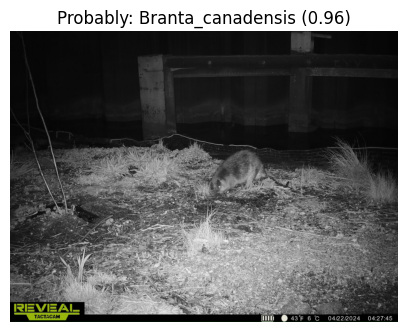

In [23]:
image_path = '/kaggle/working/_tests/Castor_canadensis.jpg'
pred, pred_idx, probs = learn.predict(PILImage.create(image_path))


PILImage.create(image_path).show(title=f"Probably: {pred} ({probs[pred_idx]:.2f})")

In [25]:
test_path = Path("/kaggle/working/_tests")
test_files = get_image_files(test_path)

results = []
for f in test_files:
    pred_class, pred_idx, pred_probs = learn.predict(f)
    results.append({
        'file': f.name,
        'pred_class': str(pred_class),
        'probability': float(pred_probs[pred_idx]),
        'top3': [
            (learn.dls.vocab[i], format(float(pred_probs[i]), ".4f"))
            for i in pred_probs.argsort(descending=True)[:3]
        ]
    })

import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)

,file,pred_class,probability,top3
0,Actitis_macularius.jpg,Actitis_macularius,0.894475,"[(Actitis_macularius, 0.8945), (Trachemys_scripta_elegans, 0.0417), (Anas_platyrhynchos, 0.0168)]"
1,Canis_familiaris.jpg,Canis_familiaris,0.990874,"[(Canis_familiaris, 0.9909), (blank, 0.0047), (Anas_platyrhynchos, 0.0021)]"
2,Castor_canadensis.jpg,Branta_canadensis,0.961451,"[(Branta_canadensis, 0.9615), (Castor_canadensis, 0.0252), (Anas_platyrhynchos, 0.0105)]"
3,Branta_canadensis.jpg,Branta_canadensis,0.999954,"[(Branta_canadensis, 1.0000), (Castor_canadensis, 0.0000), (Anas_platyrhynchos, 0.0000)]"
4,Turdus_migratorius.jpg,Turdus_migratorius,0.998716,"[(Turdus_migratorius, 0.9987), (Anas_platyrhynchos, 0.0005), (Trachemys_scripta_elegans, 0.0003)]"
5,Sylvilagus_floridanus.jpg,Sylvilagus_floridanus,0.975233,"[(Sylvilagus_floridanus, 0.9752), (Castor_canadensis, 0.0123), (Branta_canadensis, 0.0106)]"
6,Anas_platyrhynchos.jpg,Anas_platyrhynchos,0.980064,"[(Anas_platyrhynchos, 0.9801), (Branta_canadensis, 0.0131), (Trachemys_scripta_elegans, 0.0038)]"
7,Trachemys_scripta_elegans.jpg,Trachemys_scripta_elegans,0.990906,"[(Trachemys_scripta_elegans, 0.9909), (Anas_platyrhynchos, 0.0063), (Branta_canadensis, 0.0021)]"
8,blank.jpg,blank,0.751303,"[(blank, 0.7513), (Canis_familiaris, 0.1229), (Anas_platyrhynchos, 0.0790)]"


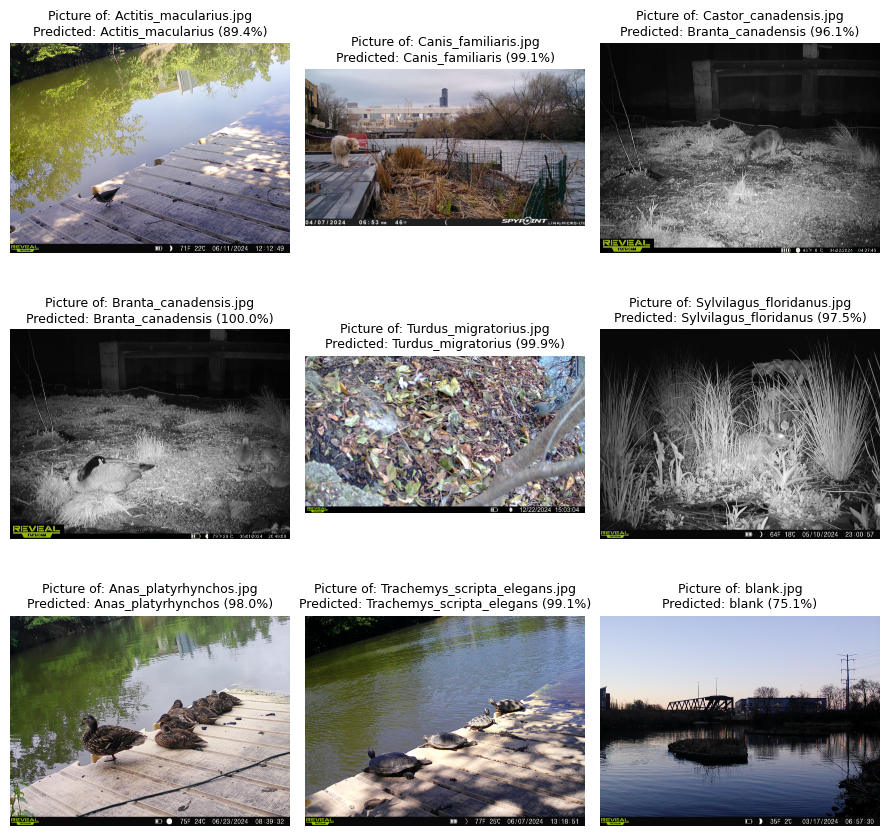

In [28]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for ax, img_file in zip(axes, test_files):
    img = PILImage.create(img_file)
    pred_class, pred_idx, pred_probs = learn.predict(img)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Picture of: {img_file.name}\nPredicted: {pred_class} ({pred_probs[pred_idx]:.1%})", fontsize=9)

# Hide unused subplots if fewer than 9 images
for ax in axes[len(test_files):]:
    ax.axis('off')

plt.tight_layout()
plt.show()